In [1]:
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

C:\Users\ajitp\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline
plt.style.use('ggplot')

from sklearn import model_selection, preprocessing, metrics
from sklearn.preprocessing import LabelEncoder

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

gc.enable()

# Data Acquisition

#### Load dataset from disk

In [3]:
features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source']

In [4]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                    chunksize = 100000)
    for df in dfs:
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis = 0).reset_index(drop = True)
        print(ans.shape)
    return ans

In [5]:
%%time
train_df = load_df("ga_mini50.csv")

C:\Users\ajitp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


Loaded ga_mini50.csv. Shape: (100000, 60)
(100000, 29)
Loaded ga_mini50.csv. Shape: (100000, 60)
(200000, 29)
Loaded ga_mini50.csv. Shape: (794, 60)
(200794, 29)
Wall time: 1min 29s


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200794 entries, 0 to 200793
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   channelGrouping             200794 non-null  object
 1   date                        200794 non-null  int64 
 2   fullVisitorId               200794 non-null  object
 3   visitId                     200794 non-null  int64 
 4   visitNumber                 200794 non-null  int64 
 5   visitStartTime              200794 non-null  int64 
 6   device.browser              200794 non-null  object
 7   device.deviceCategory       200794 non-null  object
 8   device.isMobile             200794 non-null  bool  
 9   device.operatingSystem      200794 non-null  object
 10  geoNetwork.city             200794 non-null  object
 11  geoNetwork.continent        200794 non-null  object
 12  geoNetwork.country          200794 non-null  object
 13  geoNetwork.metro            2

In [7]:
train_df.shape

(200794, 29)

#### Analyze the customers generating the revenue
#### Also discover the unique customers

In [8]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [9]:
total_revenue = gdf['totals.transactionRevenue'].sum()
print (f"Total Revenue: {total_revenue}");

Total Revenue: 283819170000.0


In [10]:
non_zero_instance_count = pd.notnull(train_df["totals.transactionRevenue"]).sum()
non_zero_total_revenue = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", non_zero_instance_count, " and ratio is : ", non_zero_instance_count / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", non_zero_total_revenue, "and the ratio is : ", non_zero_total_revenue / gdf.shape[0])

Number of instances in train set with non-zero revenue :  2269  and ratio is :  0.011300138450352102
Number of unique customers with non-zero revenue :  2150 and the ratio is :  0.01299651209884603


# Missing value details

In [11]:
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    
    print("\n Total of Sales % of Total: ", round((data[data['totals.transactionRevenue'] != np.nan]['totals.transactionRevenue'].count() / len(data['totals.transactionRevenue']) * 100),4))
    
    return

In [12]:
missing_values(train_df)

Total columns at least one Values: 
                             Total    Percent
totals.transactionRevenue   198525  98.869986
trafficSource.isTrueDirect  126504  63.001883
totals.bounces              109498  54.532506
totals.newVisits             57953  28.861918
trafficSource.keyword        19887   9.904180
totals.pageviews                46   0.022909

 Total of Sales % of Total:  1.13


# Distribution of traget variable (totals.transactionRevenue)

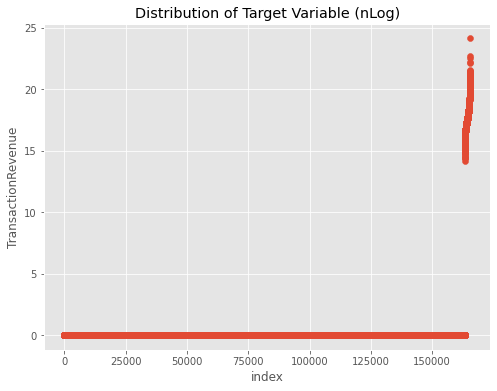

In [13]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
#plt.hist( gdf["totals.transactionRevenue"].values)
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.title('Distribution of Target Variable (nLog)')
plt.show()

#### As Dataset description says 80/20 rule

#### only 20% of customers are responsible for 80% or total transactions

In [14]:
len(train_df)

200794

# Ratio of revenue generating customers

In [15]:
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
nrc = gdf[gdf['totals.transactionRevenue']==0]
rc = gdf[gdf['totals.transactionRevenue']>0]
print("The number of nonrevenue customers are ", len(nrc))
print("The number of revenue generating customers are ", len(rc))
print("the ratio of revenue generating customers are {0:0.4}%".format(len(rc)/len(gdf)*100))

The number of nonrevenue customers are  163279
The number of revenue generating customers are  2150
the ratio of revenue generating customers are 1.3%


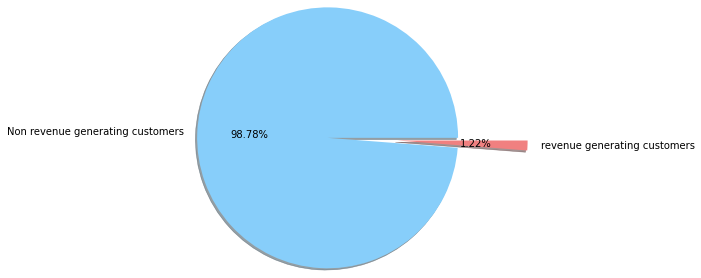

In [16]:
labels = ['Non revenue generating customers','revenue generating customers']
values = [1307589,16141]

plt.axis("equal")
plt.pie(values, labels=labels, radius=1.5, autopct="%0.2f%%",shadow=True, explode=[0,0.8], colors=['lightskyblue','lightcoral'])
plt.show()

In [17]:
train_df['totals.transactionRevenue'].fillna(0.0, inplace=True)

## If we only consider non zero transactionRevenue

In [18]:
nzr = train_df[train_df['totals.transactionRevenue']>0]['totals.transactionRevenue']
nzr.describe()

count    2.269000e+03
mean     1.250856e+08
std      6.928428e+08
min      1.390000e+06
25%      2.398000e+07
50%      4.796000e+07
75%      9.595000e+07
max      3.016994e+10
Name: totals.transactionRevenue, dtype: float64

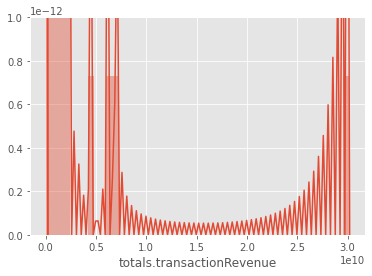

In [19]:
sns.distplot(nzr)

#### distribution is not normal and also submission must be done in log format so better transform it

In [20]:
log_revenue = train_df["totals.transactionRevenue"].apply(np.log1p)

In [21]:
log_revenue[log_revenue>0].head()

34     17.057321
136    16.682841
192    17.420465
204    18.766113
323    16.906098
Name: totals.transactionRevenue, dtype: float64

#### Distribution of non zero transactionRevenue

Text(0.5, 1.0, 'nLog Distribution of Transaction Revenue')

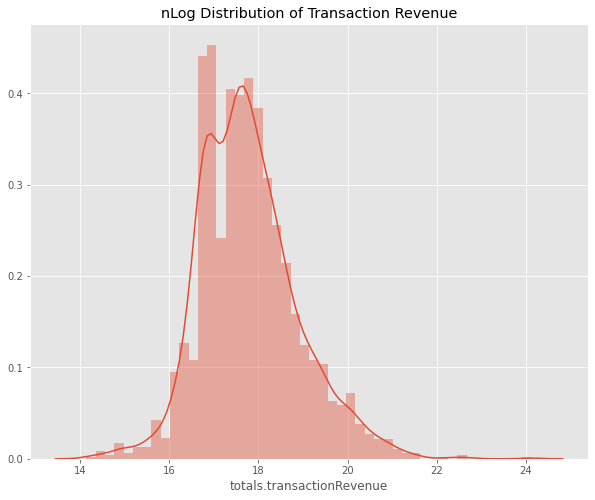

In [22]:
plt.figure(figsize=(10,8))
nzr = log_revenue[log_revenue>0]
sns.distplot(nzr)
plt.title('nLog Distribution of Transaction Revenue')

In [23]:
from scipy.stats import kurtosis, skew
total = nzr
print("The skewness of the transaction value ", skew(total))
print("The kurtosis of the transaction value ", kurtosis(total))

The skewness of the transaction value  0.6112308392167833
The kurtosis of the transaction value  1.2585203833859708


###### skewness is just 0.3, so it is almost symmetrical
###### kurtosis is more than 1 shows that it is little sharp i.e, not a perfect bell shaped curve

# Feature engineering of Date and  visitStartTime column

In [24]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20180701,4363089508398006729,1530430365,1,1530430365,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,rr.com,not available in demo dataset,Northern America,1,1,1,1,0.0,(not set),(not set),NaN,(not provided),organic,(not set),google
1,Social,20180722,872438495180459452,1532288393,2,1532288393,Safari (in-app),mobile,True,iOS,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,NaN,8,NaN,4,0.0,(not set),(not set),NaN,(not set),referral,/yt/lineups/index.html,youtube.com
2,Organic Search,20180701,61732750034868310,1530457094,1,1530457094,Chrome,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,verizon.net,not available in demo dataset,Northern America,NaN,11,1,9,0.0,(not set),(not set),NaN,(not provided),organic,(not set),google
3,Organic Search,20180927,7810944802312008431,1538089295,2,1538089295,Safari,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,comcastbusiness.net,California,Northern America,NaN,2,NaN,2,0.0,(not set),(not set),True,(not provided),organic,(not set),google
4,Organic Search,20181004,2050355776516988356,1538638689,1,1538638689,Chrome,desktop,False,Windows,London,Europe,United Kingdom,London,sli-systems.com,England,Northern Europe,1,1,1,1,0.0,(not set),(not set),NaN,(not provided),organic,(not set),google


In [25]:
# library of datetime
from datetime import datetime

#weekday Format: 0=Monday, 6=Sunday
#Day Format: Day of month

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [26]:
train_df = date_process(train_df)

In [27]:
train_df[["date","_weekday","_day","_month","_year","_visitHour"]].head()

,date,_weekday,_day,_month,_year,_visitHour
0,2018-07-01,6,1,7,2018,3
1,2018-07-22,6,22,7,2018,15
2,2018-07-01,6,1,7,2018,10
3,2018-09-27,3,27,9,2018,19
4,2018-10-04,3,4,10,2018,3


In [28]:
train_copy = train_df.copy()

In [29]:
train_copy.shape

(200794, 34)

# Exploring Data Timeline

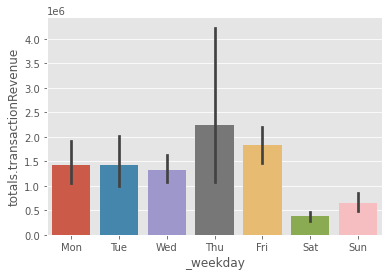

In [30]:
sns.barplot(x=train_df['_weekday'], y=train_df['totals.transactionRevenue'], data=train_df)
plt.xticks(np.arange(7),('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()

##### <i>Weeak day 0 is Monday
##### <i>on weekdays we can expect more sales
##### <i>on weekends sales are less 

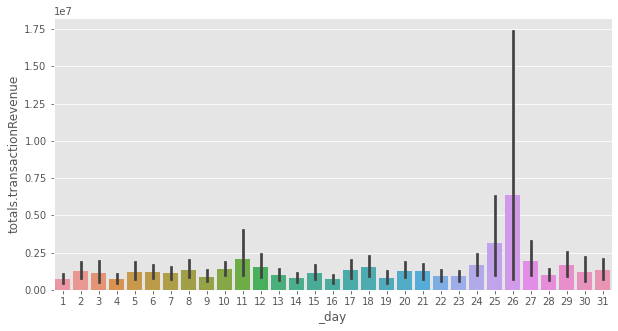

In [31]:
%matplotlib inline
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_day'], y=train_df['totals.transactionRevenue'], data=train_df)

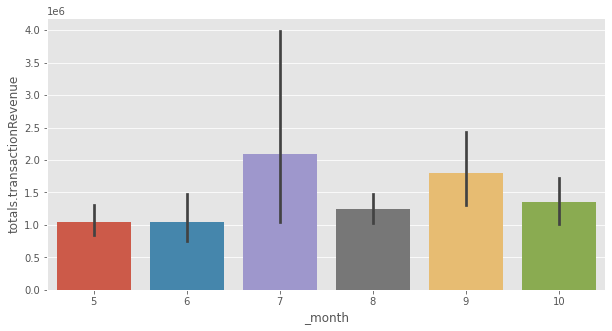

In [32]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_month'], y=train_df['totals.transactionRevenue'], data=train_df)

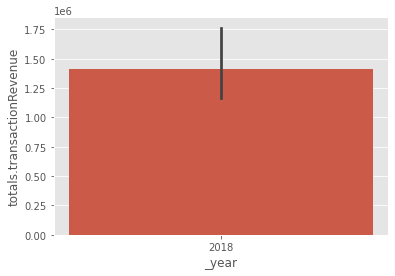

In [33]:
sns.barplot(x=train_df['_year'], y=train_df['totals.transactionRevenue'], data=train_df)

In [34]:
train_df['date'].describe()

count                  200794
unique                    168
top       2018-10-09 00:00:00
freq                     1924
first     2018-05-01 00:00:00
last      2018-10-15 00:00:00
Name: date, dtype: object

###### train set consists of data from 1st August 2016   to   30th April 2018

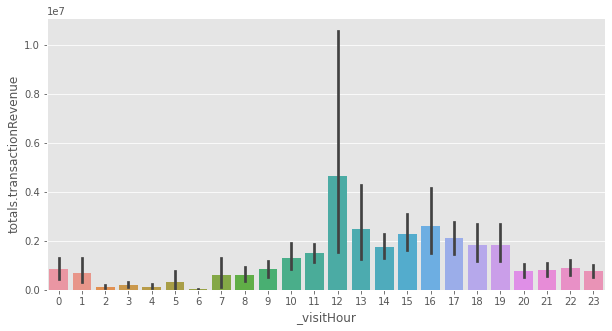

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_visitHour'], y=train_df['totals.transactionRevenue'], data=train_df)

##### 9AM to 11PM ,revenue generation is high  
####  After 12AM, till 6AM, revenue generation is very less

# Date v/s  transactionRevenue

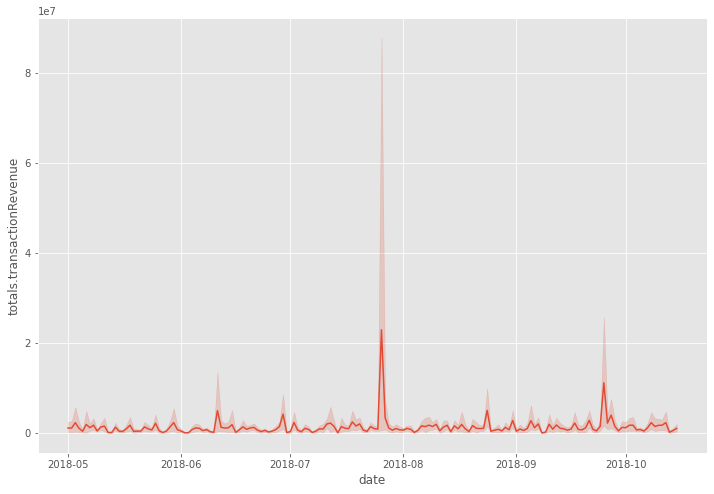

In [36]:
plt.figure(figsize=(12, 8))
#plt.style.use('fivethirtyeight')
sns.lineplot(train_df['date'], train_df['totals.transactionRevenue'])

## Date v/s userCounts  in train set

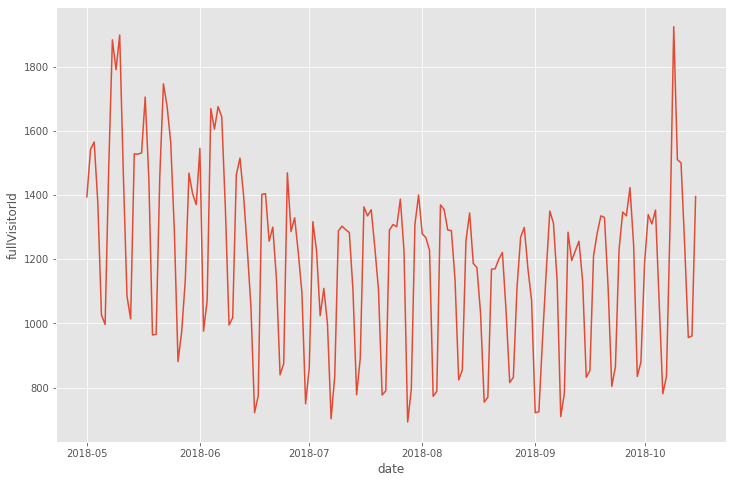

In [37]:
cnt_srs = train_df.groupby('date')['fullVisitorId'].size().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(cnt_srs['date'], cnt_srs['fullVisitorId'])

##### huge spike(customers) visited google store from september 2017 to november 2017,
##### December 2017 is highest spike
##### Oct 2016 to Nov 2016 shows an extreme rally as well

# Exploratory Data Analysis

### function to exctract columns of specific category

In [38]:
import re
def columns_extract(category):
    cat_cols = list()
    for i in train_df.columns: 
        a = re.findall(r'^'+category+'.*',i)
        if a:
            cat_cols.append(a[0])
        else:
            continue
    return cat_cols

### function to plot specific attributes

In [39]:
def category_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    #a['totals.transactionRevenue'] = a['totals.transactionRevenue'].apply(np.expm1)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean transaction value"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean transaction value']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(8, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(x=cnt_srs['count'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,2)
    sns.barplot(x=cnt_srs['count of non-zero revenue'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,3)
    sns.barplot(x=cnt_srs['mean transaction value'].head(10), y=cnt_srs.index[:10])
    plt.subplot(4,1,4)
    sns.barplot(x=cnt_srs['total_revenue'].head(10), y=cnt_srs.index[:10])

#cnt_srs

# Exploring Device attributes

In [40]:
device_cols = columns_extract('device')

In [41]:
train_df[device_cols].nunique(dropna=False)

device.browser            44
device.deviceCategory      3
device.isMobile            2
device.operatingSystem    20
dtype: int64

##### explorable columns   'device.browser',  'device.deviceCategory',  'device.operatingSystem '

                    count  count of non-zero revenue  mean transaction value  \
device.browser                                                                 
Chrome             152953                       2048            1.184675e+08   
Safari              28864                        159            4.781767e+07   
Firefox              6230                         30            1.064190e+09   
Opera Mini           2576                          0                     NaN   
Internet Explorer    2246                         14            4.524000e+07   
Edge                 2152                         10            6.808500e+07   
Samsung Internet     1599                          6            4.831333e+07   
Android Webview      1317                          0                     NaN   
Safari (in-app)       966                          0                     NaN   
Opera                 957                          2            3.247500e+07   

                   total_revenue  
devi

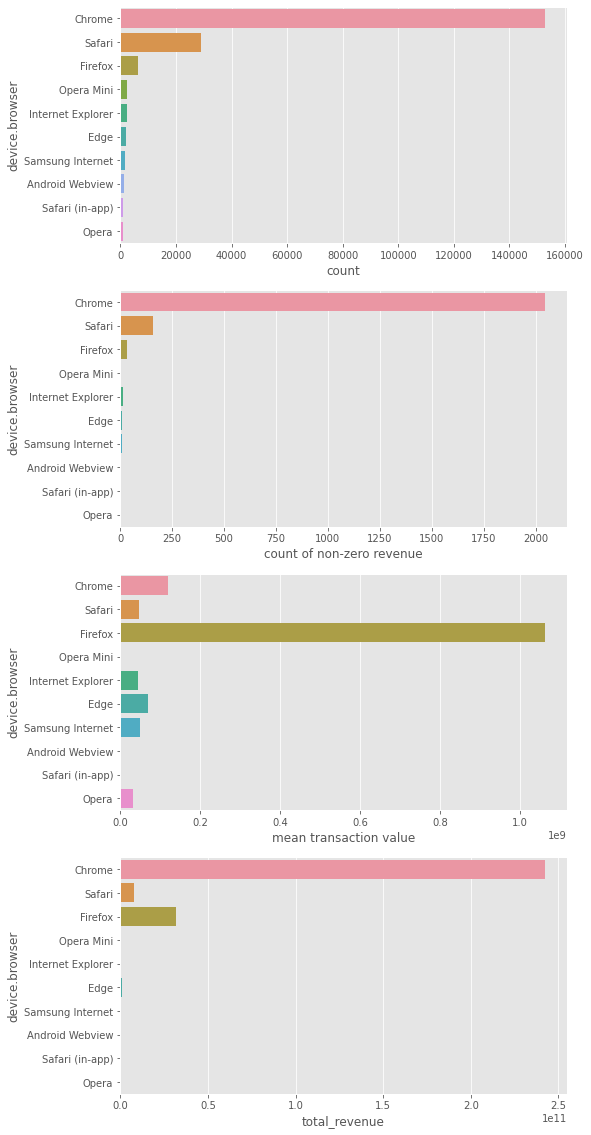

In [42]:
category_plots('device.browser')

###### though safari users are more , revenue generating customers are less
###### firefox users generate a more mean value
###### only chrome users are major source of revenue generation

# What devices access the internet mostly?

                        count  count of non-zero revenue  \
device.deviceCategory                                      
desktop                138996                       2032   
mobile                  55790                        207   
tablet                   6008                         30   

                       mean transaction value  total_revenue  
device.deviceCategory                                         
desktop                          1.346994e+08   2.737092e+11  
mobile                           4.336039e+07   8.975600e+09  
tablet                           3.781267e+07   1.134380e+09  


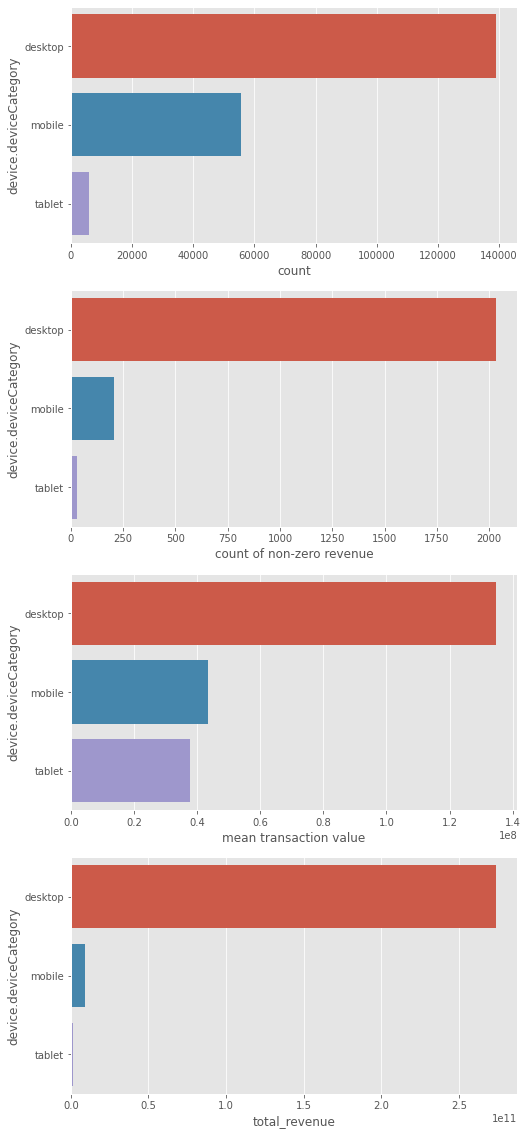

In [43]:
category_plots('device.deviceCategory')

##### Desktop users generate more revenue

# Which OS access the internet mostly?

                        count  count of non-zero revenue  \
device.operatingSystem                                     
Windows                 69504                        353   
Macintosh               51126                       1177   
Android                 32802                        111   
iOS                     26423                        127   
Chrome OS               10249                        338   
Linux                    8192                        163   
(not set)                2172                          0   
Samsung                   190                          0   
Tizen                      48                          0   
Windows Phone              46                          0   

                        mean transaction value  total_revenue  
device.operatingSystem                                         
Windows                           1.894944e+08   6.689154e+10  
Macintosh                         1.345392e+08   1.583526e+11  
Android                

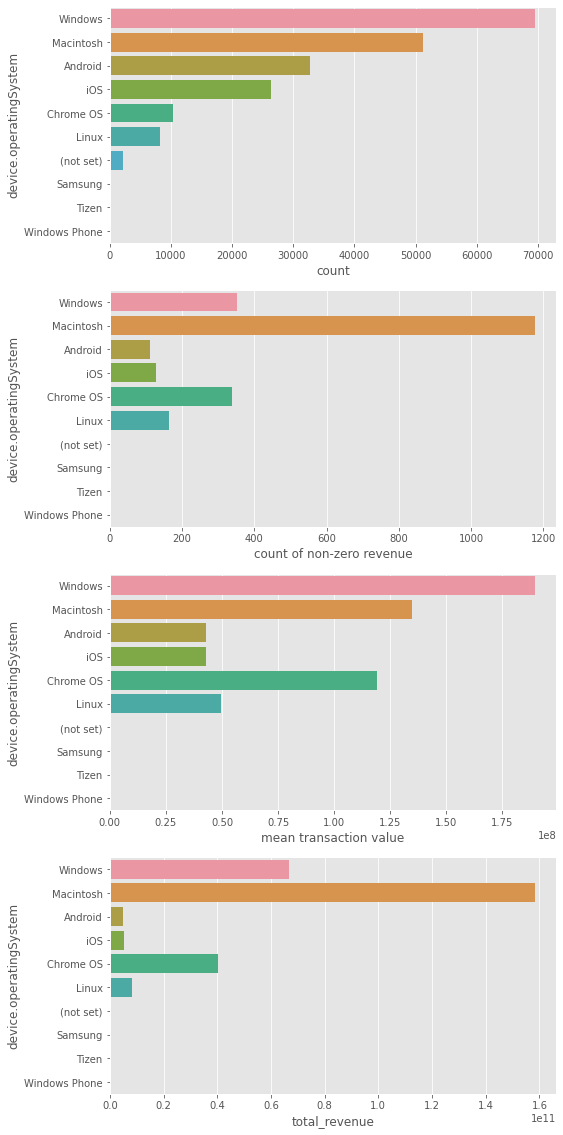

In [44]:
category_plots('device.operatingSystem')

###### windows users are more 
###### revenue generating users are more in Mac category
###### mean revenue of chromse OS is high
###### definitely MAC, windows, chrome OS users are source of revenue generation

# Exploring Geonetwork category

In [45]:
geo_clos = columns_extract('geoNetwork')

In [46]:
train_df[geo_clos].nunique(dropna=False)

geoNetwork.city               502
geoNetwork.continent            6
geoNetwork.country            196
geoNetwork.metro               82
geoNetwork.networkDomain    10806
geoNetwork.region             269
geoNetwork.subContinent        23
dtype: int64

###### explorable columns are   geoNetwork.continent,   geoNetwork.country,     geoNetwork.subContinent ,   geoNetwork.networkDomain

######  geoNetwork.continent

                       count  count of non-zero revenue  \
geoNetwork.continent                                      
Americas              108497                       2181   
Asia                   43015                         35   
Europe                 41888                         49   
Oceania                 3844                          4   
Africa                  3349                          0   
(not set)                201                          0   

                      mean transaction value  total_revenue  
geoNetwork.continent                                         
Americas                        1.237708e+08   2.699441e+11  
Asia                            1.918274e+08   6.713960e+09  
Europe                          1.092684e+08   5.354150e+09  
Oceania                         4.517450e+08   1.806980e+09  
Africa                                   NaN            NaN  
(not set)                                NaN            NaN  


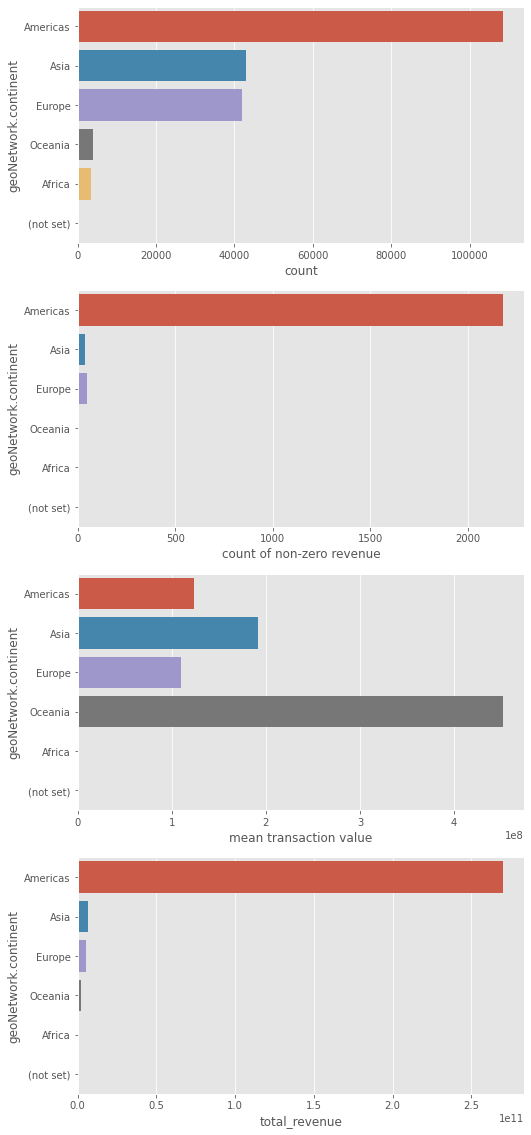

In [47]:
category_plots('geoNetwork.continent')

###### though Asia and Europe has descent number of users,   revenue generating users almost NIL
###### Africa has remarkably large mean value
###### Absolutely Americans are the major source of revenue generation

                    count  count of non-zero revenue  mean transaction value  \
geoNetwork.country                                                             
United States       90353                       2129            1.240535e+08   
India               14359                          2            5.498000e+07   
United Kingdom       9238                         39            1.219569e+08   
Canada               6530                         39            1.203641e+08   
Japan                5471                         13            3.564585e+08   
Taiwan               5290                          7            8.572714e+07   
Germany              4764                          1            1.407200e+08   
France               3718                          0                     NaN   
Brazil               3537                          3            6.095667e+07   
Spain                3321                          2            4.278500e+07   

                    total_revenue  
geo

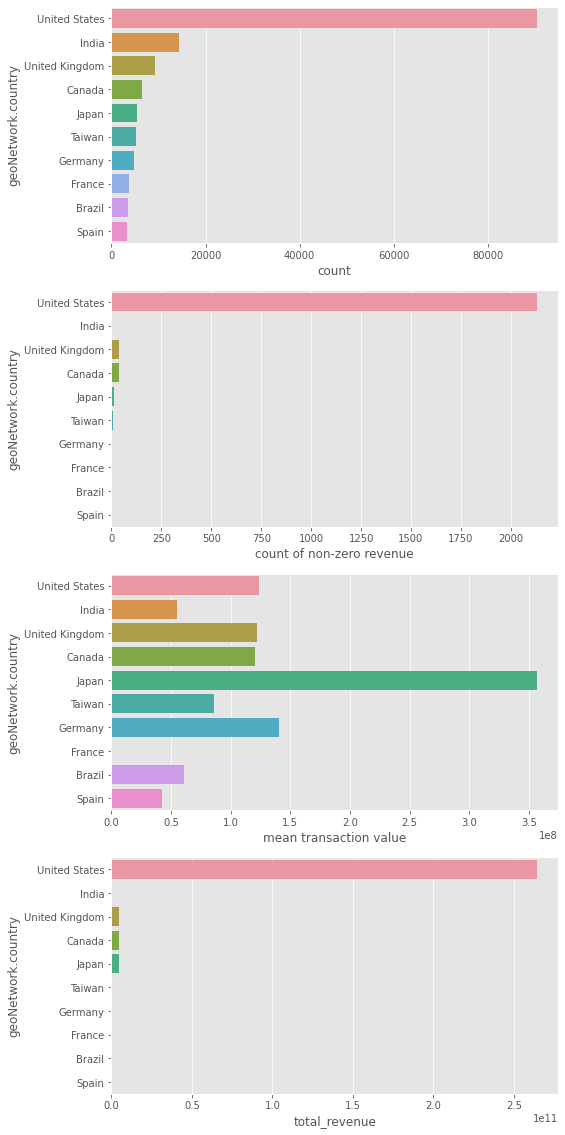

In [48]:
category_plots('geoNetwork.country')

###### Except North America other subcontinents has countable number of revenue generating customers
###### North America is the clear winner in generating revenue generation

                         count  count of non-zero revenue  \
geoNetwork.subContinent                                     
Northern America         96890                       2169   
Southern Asia            16088                          2   
Eastern Asia             15140                         26   
Western Europe           13780                          2   
Northern Europe          13589                         41   
South America             8494                          7   
Southern Europe           8089                          4   
Southeast Asia            8020                          7   
Eastern Europe            6430                          2   
Australasia               3821                          4   

                         mean transaction value  total_revenue  
geoNetwork.subContinent                                         
Northern America                   1.239332e+08   2.688110e+11  
Southern Asia                      5.498000e+07   1.099600e+08  
Eastern

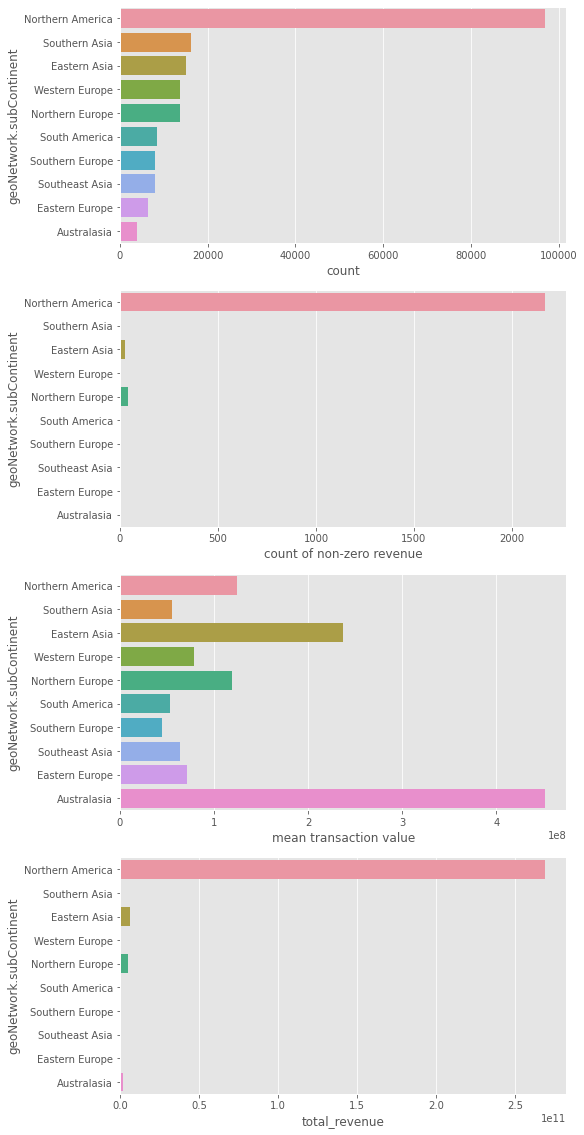

In [49]:
category_plots('geoNetwork.subContinent')

                          count  count of non-zero revenue  \
geoNetwork.networkDomain                                     
(not set)                 68851                       1407   
unknown.unknown           28581                         79   
comcast.net                7109                        179   
rr.com                     3309                         76   
verizon.net                3189                         84   
hinet.net                  2426                          1   
comcastbusiness.net        2008                         54   
sbcglobal.net              1586                         46   
virginm.net                1279                          0   
cox.net                    1181                         23   

                          mean transaction value  total_revenue  
geoNetwork.networkDomain                                         
(not set)                           1.156257e+08   1.626854e+11  
unknown.unknown                     1.010313e+08   7.9814

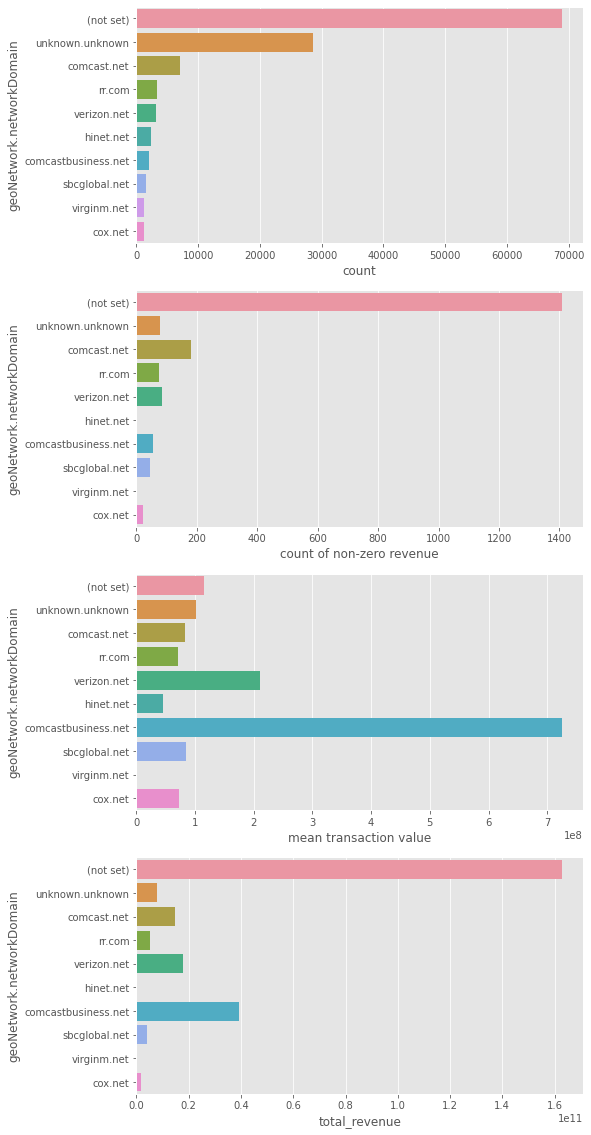

In [50]:
category_plots('geoNetwork.networkDomain')

#  Exploring traffic Source category

In [51]:
traffic_cols = columns_extract('trafficSource')

In [52]:
train_df[traffic_cols].nunique(dropna=False)

trafficSource.adContent         24
trafficSource.campaign          25
trafficSource.isTrueDirect       2
trafficSource.keyword          408
trafficSource.medium             7
trafficSource.referralPath    1361
trafficSource.source           163
dtype: int64

##### explorable columns are    trafficSource.source,     trafficSource.referralPath,      trafficSource.medium,   trafficSource.source

                             count  count of non-zero revenue  \
trafficSource.source                                            
google                      104329                        907   
(direct)                     55562                       1284   
youtube.com                  14098                          6   
analytics.google.com          6392                          0   
Partners                      5468                          3   
dfa                           3315                         17   
sites.google.com              2727                         16   
creatoracademy.youtube.com    1766                          0   
google.com                     670                          3   
bing                           666                          9   

                            mean transaction value  total_revenue  
trafficSource.source                                               
google                                9.877121e+07   8.958549e+10  
(direct)       

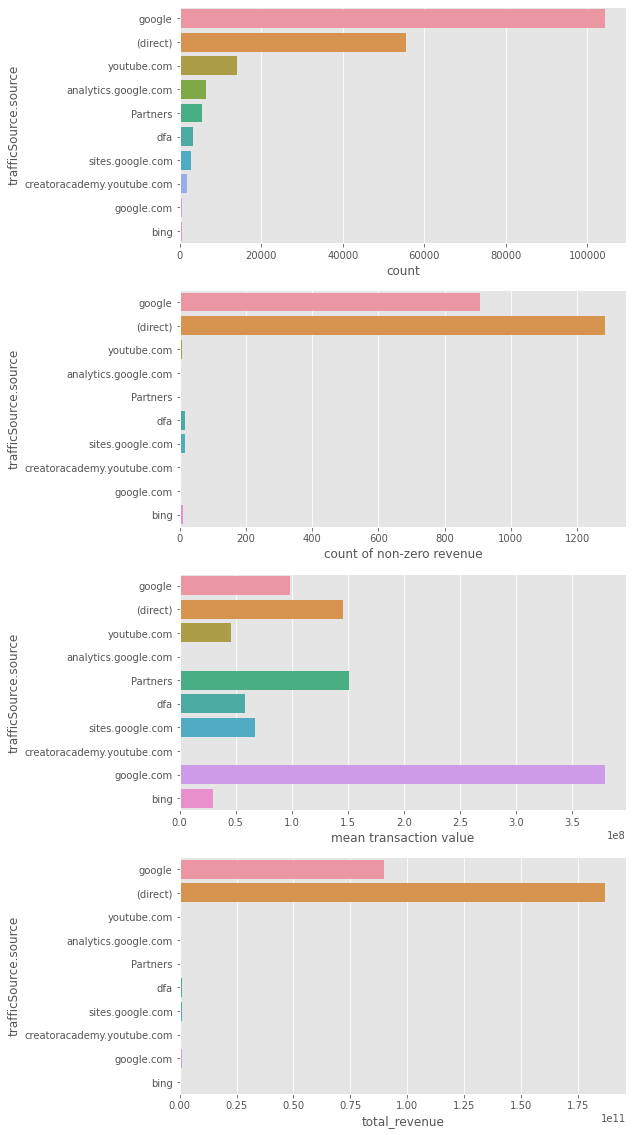

In [53]:
category_plots('trafficSource.source')

###### though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
######  revenue generating customers are more in mall.googleplex.com
###### dfa has highest mean transaction value
###### mall.googleplex.com generates more revenue

                      count  count of non-zero revenue  \
trafficSource.medium                                     
organic               99222                        821   
(none)                55557                       1284   
referral              30590                         44   
cpc                    6637                        100   
affiliate              5466                          3   
cpm                    3320                         17   
(not set)                 2                          0   

                      mean transaction value  total_revenue  
trafficSource.medium                                         
organic                         9.806175e+07   8.050870e+10  
(none)                          1.455378e+08   1.868705e+11  
referral                        1.234673e+08   5.432560e+09  
cpc                             9.561480e+07   9.561480e+09  
affiliate                       1.508467e+08   4.525400e+08  
cpm                             5.843294e+0

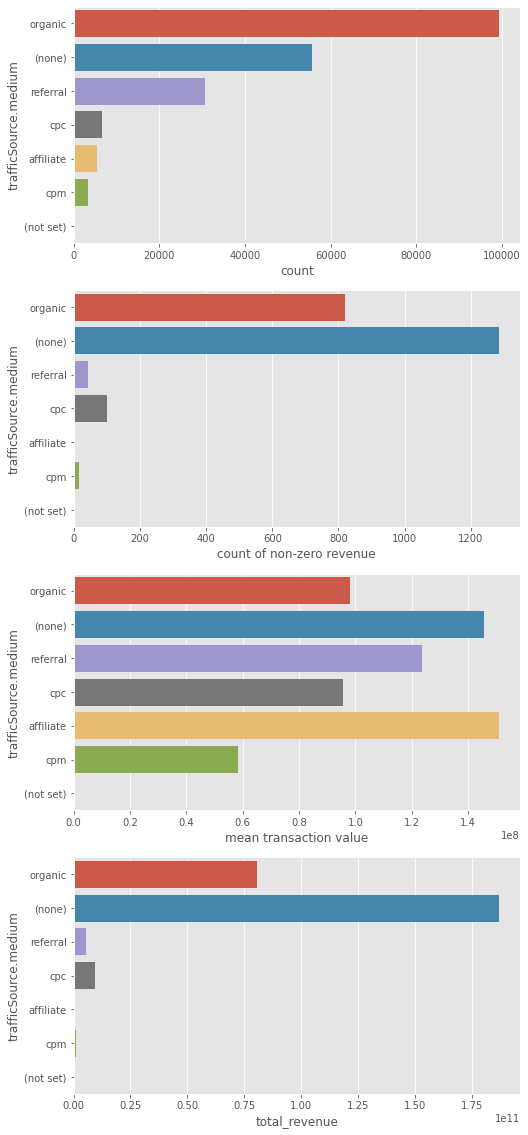

In [54]:
category_plots('trafficSource.medium')

### Most Ad Content

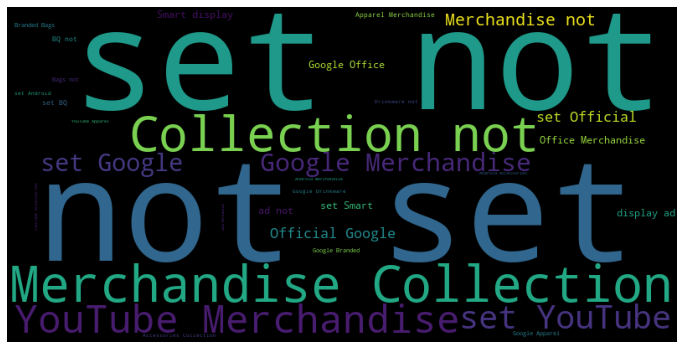

In [55]:
from wordcloud import WordCloud

ad_content = train_df['trafficSource.adContent'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(ad_content))
plt.figure( figsize=(12,9))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

##  from which source  users are visiting? 

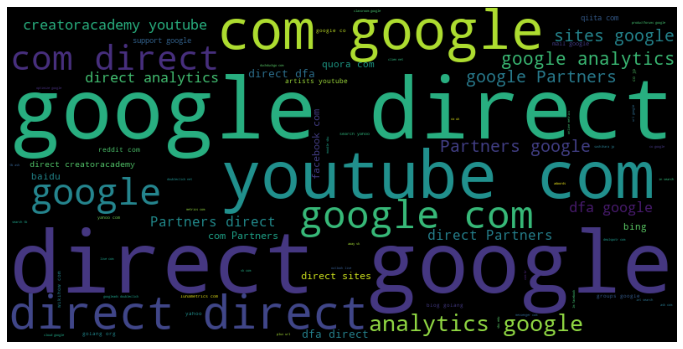

In [56]:
source = train_df['trafficSource.source'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure( figsize=(12,10) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# Exploring totals  category

In [57]:
total_cols = columns_extract('totals')

In [58]:
train_df[total_cols].nunique(dropna=False)

totals.bounces                  2
totals.hits                   172
totals.newVisits                2
totals.pageviews              124
totals.transactionRevenue    1108
dtype: int64

### explorable columns are  totals.hits, totals.pageviews

In [59]:
def total_col_plots(col):
    a = train_df.loc[:,[col, 'totals.transactionRevenue']]
    a['totals.transactionRevenue'] = a['totals.transactionRevenue'].replace(0.0, np.nan)
    #a['totals.transactionRevenue'] = a['totals.transactionRevenue'].apply(np.expm1)
    cnt_srs = a.groupby(col)['totals.transactionRevenue'].agg(['size','count','mean'])
    cnt_srs.columns = ["count", 'count of non-zero revenue', "mean"]

    cnt_srs['total_revenue'] = cnt_srs['count of non-zero revenue']*cnt_srs['mean']
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    print(cnt_srs.head(10))
    plt.figure(figsize=(15, 20)) 
    plt.subplot(4,1,1)
    sns.barplot(y=cnt_srs['count'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,2)
    sns.barplot(y=cnt_srs['count of non-zero revenue'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,3)
    sns.barplot(y=cnt_srs['mean'].head(50), x=list(range(1,51)))
    plt.subplot(4,1,4)
    sns.barplot(y=cnt_srs['total_revenue'].head(50), x=list(range(1,51)))

#cnt_srs

             count  count of non-zero revenue          mean  total_revenue
totals.hits                                                               
1            90507                          0           NaN            NaN
2            23196                          3  7.396000e+07   2.218800e+08
3            16918                          1  6.292000e+07   6.292000e+07
4            10648                          0           NaN            NaN
5             8630                          1  1.759000e+07   1.759000e+07
6             6862                          0           NaN            NaN
7             5894                          6  5.449167e+07   3.269500e+08
8             4591                         16  4.958938e+07   7.934300e+08
9             3750                         14  1.670657e+08   2.338920e+09
10            3347                         35  9.622829e+07   3.367990e+09


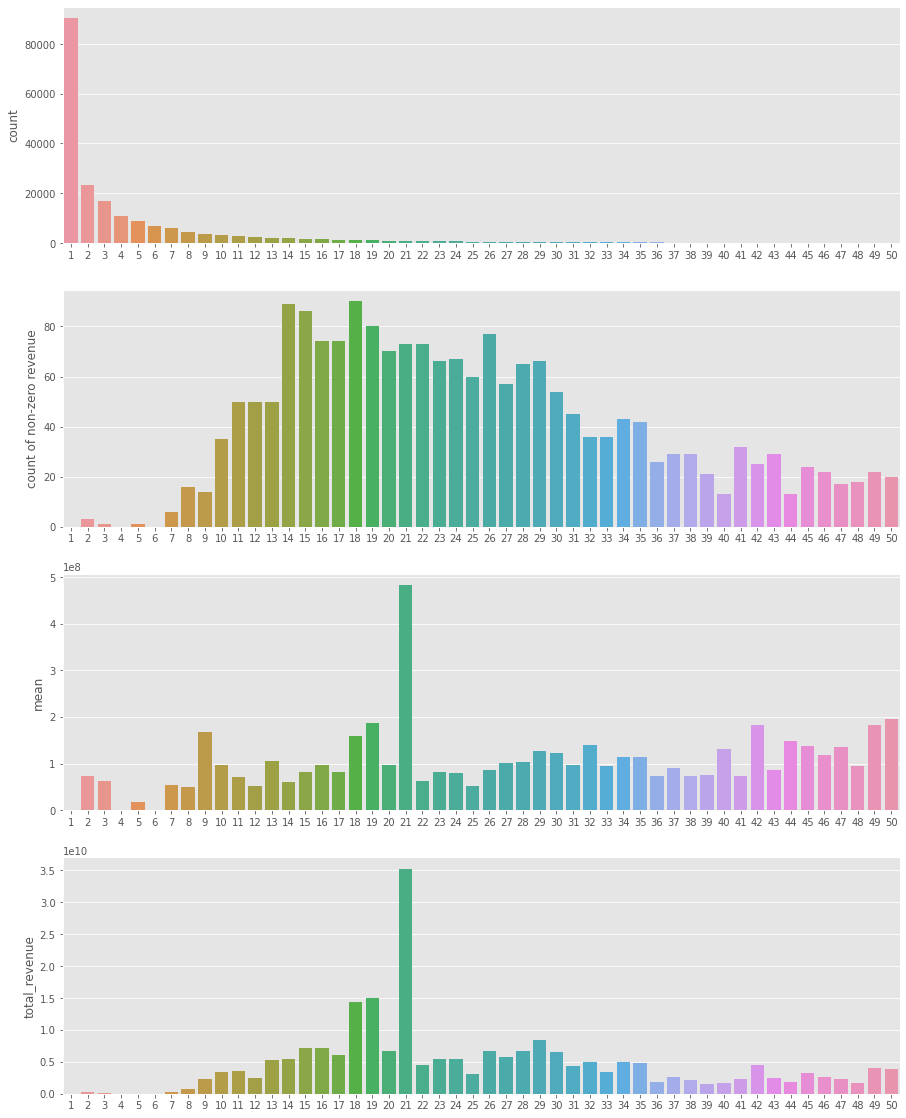

In [60]:
total_col_plots('totals.hits')

                  count  count of non-zero revenue          mean  \
totals.pageviews                                                   
1                 91939                          0           NaN   
2                 26120                          3  7.396000e+07   
3                 18119                          1  6.292000e+07   
4                 11820                          0           NaN   
5                  9262                          1  1.759000e+07   
6                  7113                          1  1.039000e+07   
7                  5681                         12  4.634083e+07   
8                  4647                         20  1.310130e+08   
9                  3745                         39  1.053126e+08   
10                 3071                         62  8.673306e+07   

                  total_revenue  
totals.pageviews                 
1                           NaN  
2                  2.218800e+08  
3                  6.292000e+07  
4            

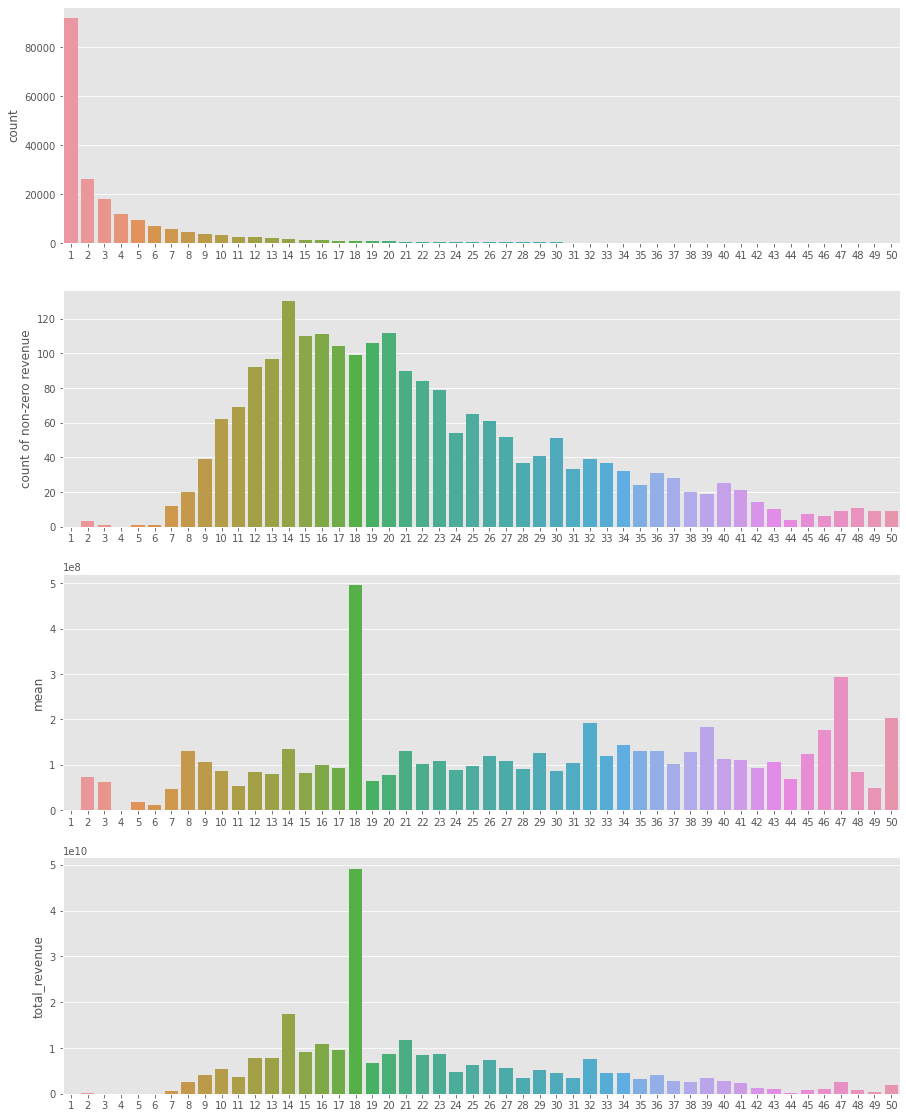

In [61]:
total_col_plots('totals.pageviews')

###### both plots looks similar
######  when the pagehits, revenue generation may increase, but not always

In [62]:
train_df.dtypes

channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                        object
device.deviceCategory                 object
device.isMobile                         bool
device.operatingSystem                object
geoNetwork.city                       object
geoNetwork.continent                  object
geoNetwork.country                    object
geoNetwork.metro                      object
geoNetwork.networkDomain              object
geoNetwork.region                     object
geoNetwork.subContinent               object
totals.bounces                        object
totals.hits                           object
totals.newVisits                      object
totals.pageviews                      object
totals.transactionRevenue            float64
trafficSou

In [63]:
categorical_cols = list()
for i in train_df.columns:
    if (train_df[i].dtype=='object' or train_df[i].dtype=='bool') and (not(i.startswith('total'))):
        categorical_cols.append(i)

In [64]:
len(categorical_cols)

20

In [65]:
train_df[categorical_cols].nunique(dropna=False)

channelGrouping                    8
fullVisitorId                 165429
device.browser                    44
device.deviceCategory              3
device.isMobile                    2
device.operatingSystem            20
geoNetwork.city                  502
geoNetwork.continent               6
geoNetwork.country               196
geoNetwork.metro                  82
geoNetwork.networkDomain       10806
geoNetwork.region                269
geoNetwork.subContinent           23
trafficSource.adContent           24
trafficSource.campaign            25
trafficSource.isTrueDirect         2
trafficSource.keyword            408
trafficSource.medium               7
trafficSource.referralPath      1361
trafficSource.source             163
dtype: int64

###### better remove fullVisitorId from categorical_cols to avoid label encoding of fullvisitorId

In [66]:
categorical_cols

['channelGrouping',
 'fullVisitorId',
 'device.browser',
 'device.deviceCategory',
 'device.isMobile',
 'device.operatingSystem',
 'geoNetwork.city',
 'geoNetwork.continent',
 'geoNetwork.country',
 'geoNetwork.metro',
 'geoNetwork.networkDomain',
 'geoNetwork.region',
 'geoNetwork.subContinent',
 'trafficSource.adContent',
 'trafficSource.campaign',
 'trafficSource.isTrueDirect',
 'trafficSource.keyword',
 'trafficSource.medium',
 'trafficSource.referralPath',
 'trafficSource.source']

In [67]:
categorical_cols.remove('fullVisitorId')

#### numerical coloumns

In [68]:
numerical_cols = list()
for i in train_df.columns:
    if train_df[i].dtype not in ['object', 'bool']:
        numerical_cols.append(i)

In [69]:
numerical_cols

['date',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_year',
 '_visitHour']

##### remove columns which don't add value to our analysis

In [70]:
numerical_cols.remove('date')
numerical_cols.remove('visitId')
numerical_cols.remove('visitStartTime')
numerical_cols.remove('_year')

In [71]:
numerical_cols

['visitNumber',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_visitHour']

In [72]:
len(numerical_cols) + len(categorical_cols)

25

In [73]:
set(train_df.columns)-set(numerical_cols + categorical_cols)

{'_year',
 'date',
 'fullVisitorId',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'visitId',
 'visitStartTime'}

In [74]:
numerical_cols.append('totals.bounces')
numerical_cols.append('totals.hits')
numerical_cols.append('totals.newVisits')
numerical_cols.append('totals.pageviews')

In [75]:
numerical_cols

['visitNumber',
 'totals.transactionRevenue',
 '_weekday',
 '_day',
 '_month',
 '_visitHour',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews']

# Missing value treatment 

In [76]:
train_df[numerical_cols].isnull().sum()

visitNumber                       0
totals.transactionRevenue         0
_weekday                          0
_day                              0
_month                            0
_visitHour                        0
totals.bounces               109498
totals.hits                       0
totals.newVisits              57953
totals.pageviews                 46
dtype: int64

In [77]:
train_df['totals.bounces'] = train_df['totals.bounces'].fillna(0)

train_df['totals.newVisits'] = train_df['totals.newVisits'].fillna(0)

# since null value of pageviews yields no revenue, we will fillit with 0
train_df['totals.pageviews'] = train_df['totals.pageviews'].fillna(1)


In [78]:
train_df[numerical_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200794 entries, 0 to 200793
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   visitNumber                200794 non-null  int64  
 1   totals.transactionRevenue  200794 non-null  float64
 2   _weekday                   200794 non-null  int64  
 3   _day                       200794 non-null  int64  
 4   _month                     200794 non-null  int64  
 5   _visitHour                 200794 non-null  int32  
 6   totals.bounces             200794 non-null  object 
 7   totals.hits                200794 non-null  object 
 8   totals.newVisits           200794 non-null  object 
 9   totals.pageviews           200794 non-null  object 
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 14.6+ MB


In [79]:
for col in ['totals.bounces', 'totals.hits', 'totals.newVisits','totals.pageviews' ]:
    train_df[col] = train_df[col].astype(int)

In [80]:
train_df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200794 entries, 0 to 200793
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   visitNumber                200794 non-null  int64  
 1   totals.transactionRevenue  200794 non-null  float64
 2   _weekday                   200794 non-null  int64  
 3   _day                       200794 non-null  int64  
 4   _month                     200794 non-null  int64  
 5   _visitHour                 200794 non-null  int32  
 6   totals.bounces             200794 non-null  int32  
 7   totals.hits                200794 non-null  int32  
 8   totals.newVisits           200794 non-null  int32  
 9   totals.pageviews           200794 non-null  int32  
dtypes: float64(1), int32(5), int64(4)
memory usage: 11.5 MB


#### Missing values in categorical columns

In [81]:
a = train_df[categorical_cols].isnull().sum()

In [82]:
b = a/len(train_df)*100

#### percentage of missing value in catrgorical columns

In [83]:
b

channelGrouping                0.000000
device.browser                 0.000000
device.deviceCategory          0.000000
device.isMobile                0.000000
device.operatingSystem         0.000000
geoNetwork.city                0.000000
geoNetwork.continent           0.000000
geoNetwork.country             0.000000
geoNetwork.metro               0.000000
geoNetwork.networkDomain       0.000000
geoNetwork.region              0.000000
geoNetwork.subContinent        0.000000
trafficSource.adContent        0.000000
trafficSource.campaign         0.000000
trafficSource.isTrueDirect    63.001883
trafficSource.keyword          9.904180
trafficSource.medium           0.000000
trafficSource.referralPath     0.000000
trafficSource.source           0.000000
dtype: float64

##### we need to consider 
#### trafficSource.adContent,  trafficSource.adwordsClickInfo.adNetworkType,   trafficSource.adwordsClickInfo.gclId 
####  trafficSource.adwordsClickInfo.isVideoAd,  trafficSource.adwordsClickInfo.page,  trafficSource.adwordsClickInfo.slot,   
####  trafficSource.isTrueDirect ,  trafficSource.keyword,    trafficSource.referralPath

In [84]:
train_df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [85]:
train_df.isnull().sum()

channelGrouping                   0
date                              0
fullVisitorId                     0
visitId                           0
visitNumber                       0
visitStartTime                    0
device.browser                    0
device.deviceCategory             0
device.isMobile                   0
device.operatingSystem            0
geoNetwork.city                   0
geoNetwork.continent              0
geoNetwork.country                0
geoNetwork.metro                  0
geoNetwork.networkDomain          0
geoNetwork.region                 0
geoNetwork.subContinent           0
totals.bounces                    0
totals.hits                       0
totals.newVisits                  0
totals.pageviews                  0
totals.transactionRevenue         0
trafficSource.adContent           0
trafficSource.campaign            0
trafficSource.isTrueDirect        0
trafficSource.keyword         19887
trafficSource.medium              0
trafficSource.referralPath  

In [86]:
##### since more than 50% of samples are missing,  we cant fill it with existing categories

In [87]:
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    train_df[col].fillna('unknown', inplace=True)

In [88]:
train_df.shape

(200794, 34)

In [89]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour
0,Organic Search,2018-07-01,4363089508398006729,1530430365,1,1530430365,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,rr.com,not available in demo dataset,Northern America,1,1,1,1,0.0,(not set),(not set),False,(not provided),organic,(not set),google,6,1,7,2018,3
1,Social,2018-07-22,872438495180459452,1532288393,2,1532288393,Safari (in-app),mobile,True,iOS,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,0,8,0,4,0.0,(not set),(not set),False,(not set),referral,/yt/lineups/index.html,youtube.com,6,22,7,2018,15
2,Organic Search,2018-07-01,61732750034868310,1530457094,1,1530457094,Chrome,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,verizon.net,not available in demo dataset,Northern America,0,11,1,9,0.0,(not set),(not set),False,(not provided),organic,(not set),google,6,1,7,2018,10
3,Organic Search,2018-09-27,7810944802312008431,1538089295,2,1538089295,Safari,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,comcastbusiness.net,California,Northern America,0,2,0,2,0.0,(not set),(not set),True,(not provided),organic,(not set),google,3,27,9,2018,19
4,Organic Search,2018-10-04,2050355776516988356,1538638689,1,1538638689,Chrome,desktop,False,Windows,London,Europe,United Kingdom,London,sli-systems.com,England,Northern Europe,1,1,1,1,0.0,(not set),(not set),False,(not provided),organic,(not set),google,3,4,10,2018,3


In [90]:
train_df.isnull().sum()

channelGrouping               0
date                          0
fullVisitorId                 0
visitId                       0
visitNumber                   0
visitStartTime                0
device.browser                0
device.deviceCategory         0
device.isMobile               0
device.operatingSystem        0
geoNetwork.city               0
geoNetwork.continent          0
geoNetwork.country            0
geoNetwork.metro              0
geoNetwork.networkDomain      0
geoNetwork.region             0
geoNetwork.subContinent       0
totals.bounces                0
totals.hits                   0
totals.newVisits              0
totals.pageviews              0
totals.transactionRevenue     0
trafficSource.adContent       0
trafficSource.campaign        0
trafficSource.isTrueDirect    0
trafficSource.keyword         0
trafficSource.medium          0
trafficSource.referralPath    0
trafficSource.source          0
_weekday                      0
_day                          0
_month  

# Featue Engineering of totals.hits and total.pageviews

#### Mean hits per geoNetwork Domain

#### Mean pageViews per geoNetwork Domain

In [91]:
train_df['mean_hits_per_networkDomain'] = train_df.groupby('geoNetwork.networkDomain')['totals.hits'].transform('mean').astype('int')
train_df['mean_pageViews_per_networkDomain'] = train_df.groupby('geoNetwork.networkDomain')['totals.pageviews'].transform('mean').astype('int')

In [92]:
    train_df[['mean_hits_per_networkDomain','mean_pageViews_per_networkDomain']].head()

,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,6,5
1,4,3
2,6,5
3,6,5
4,1,1


# Label Encoding of categorical columns

In [93]:
train_copy_new = train_df.copy()

###### make a shallow copy of Dataframes and apply changes on it

In [94]:
for col in categorical_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(train_copy_new[col].astype("str"))
    train_copy_new[col] = lbe.transform(train_copy_new[col].astype("str"))

transform column channelGrouping
transform column device.browser
transform column device.deviceCategory
transform column device.isMobile
transform column device.operatingSystem
transform column geoNetwork.city
transform column geoNetwork.continent
transform column geoNetwork.country
transform column geoNetwork.metro
transform column geoNetwork.networkDomain
transform column geoNetwork.region
transform column geoNetwork.subContinent
transform column trafficSource.adContent
transform column trafficSource.campaign
transform column trafficSource.isTrueDirect
transform column trafficSource.keyword
transform column trafficSource.medium
transform column trafficSource.referralPath
transform column trafficSource.source


In [95]:
train_copy_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,4,2018-07-01,4363089508398006729,1530430365,1,1530430365,36,1,1,19,501,2,188,81,7905,268,12,1,1,1,1,0.0,0,3,0,2,5,0,54,6,1,7,2018,3,6,5
1,7,2018-07-22,872438495180459452,1532288393,2,1532288393,37,1,1,19,501,3,81,81,9840,268,16,0,8,0,4,0.0,0,3,0,3,6,1260,159,6,22,7,2018,15,4,3
2,4,2018-07-01,61732750034868310,1530457094,1,1530457094,14,1,1,19,501,2,188,81,10095,268,12,0,11,1,9,0.0,0,3,0,2,5,0,54,6,1,7,2018,10,6,5
3,4,2018-09-27,7810944802312008431,1538089295,2,1538089295,36,0,0,6,388,2,188,69,2017,37,12,0,2,0,2,0.0,0,3,1,2,5,0,54,3,27,9,2018,19,6,5
4,4,2018-10-04,2050355776516988356,1538638689,1,1538638689,14,0,0,16,239,4,187,39,8399,72,13,1,1,1,1,0.0,0,3,0,2,5,0,54,3,4,10,2018,3,1,1


###### remove target varibale (totals.transactionRevenue) from numerical columns list

In [96]:
numerical_cols.remove('totals.transactionRevenue')

In [97]:
numerical_cols.append('mean_pageViews_per_networkDomain')
numerical_cols.append('mean_hits_per_networkDomain')

In [98]:
train_copy_new.shape

(200794, 36)

In [99]:
set(train_df.columns)-set(numerical_cols+categorical_cols)

{'_year',
 'date',
 'fullVisitorId',
 'totals.transactionRevenue',
 'visitId',
 'visitStartTime'}

In [2]:
X = train_copy_new[categorical_cols+numerical_cols]
y = train_copy_new['totals.transactionRevenue']

In [126]:
X.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'trafficSource.adContent',
       'trafficSource.campaign', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source', 'visitNumber',
       '_weekday', '_day', '_month', '_visitHour', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'mean_pageViews_per_networkDomain', 'mean_hits_per_networkDomain'],
      dtype='object')

In [127]:
X.head()

,channelGrouping,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitNumber,_weekday,_day,_month,_visitHour,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,mean_pageViews_per_networkDomain,mean_hits_per_networkDomain
0,4,36,1,1,19,501,2,188,81,7905,268,12,0,3,0,2,5,0,54,1,6,1,7,3,1,1,1,1,5,6
1,7,37,1,1,19,501,3,81,81,9840,268,16,0,3,0,3,6,1260,159,2,6,22,7,15,0,8,0,4,3,4
2,4,14,1,1,19,501,2,188,81,10095,268,12,0,3,0,2,5,0,54,1,6,1,7,10,0,11,1,9,5,6
3,4,36,0,0,6,388,2,188,69,2017,37,12,0,3,1,2,5,0,54,2,3,27,9,19,0,2,0,2,5,6
4,4,14,0,0,16,239,4,187,39,8399,72,13,0,3,0,2,5,0,54,1,3,4,10,3,1,1,1,1,1,1


# Apply Regression ML over the data

## Build Worst Model

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [102]:
#Xtr, X_valid, ytr, y_valid = train_test_split(X1, y1, test_size=0.15, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [130]:
X_train[:2]

array([[4.000e+00, 1.000e+00, 3.800e+01, 1.000e+00, 1.000e+00, 1.000e+00,
        5.010e+02, 4.000e+00, 4.700e+01, 8.100e+01, 3.329e+03, 2.680e+02,
        1.300e+01, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00,
        5.400e+01, 1.000e+00, 1.700e+01, 7.000e+00, 2.018e+03, 1.500e+01,
        1.000e+00],
       [7.000e+00, 1.000e+00, 1.400e+01, 0.000e+00, 0.000e+00, 1.600e+01,
        1.810e+02, 3.000e+00, 1.920e+02, 0.000e+00, 9.840e+03, 1.010e+02,
        1.600e+01, 0.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        9.200e+01, 2.000e+00, 2.200e+01, 8.000e+00, 2.018e+03, 2.000e+00,
        4.000e+00]])

In [103]:
# Perform k-fold Cross Validation on validation dataset
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5)

In [104]:
print ("Cross-validation Scores: ", scores)

Cross-validation Scores:  [-0.24465223  0.00148297 -0.19510685 -0.30315986 -0.15189341]


Text(0.5, 1.0, 'R-SQUARED OF WORST MODEL WITHOUT STANDARDISED FEATURES')

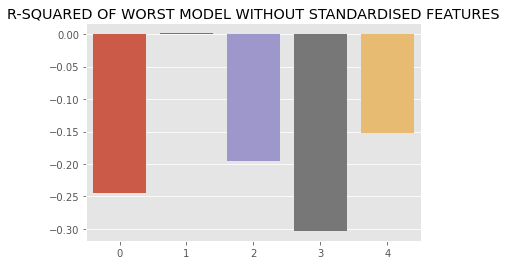

In [112]:
sns.barplot(y=scores, x=np.arange(len(scores)))
plt.title("R-SQUARED OF WORST MODEL WITHOUT STANDARDISED FEATURES")

## Now Try with Feature Scaling

In [106]:
from sklearn.preprocessing import StandardScaler
# Apply feature scaling on the data after splitting the data for train and test sets
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [107]:
# Perform k-fold Cross Validation on validation dataset
from sklearn.model_selection import cross_val_score
model = LinearRegression()
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

In [108]:
print ("Cross-validation Scores: ", scores)

Cross-validation Scores:  [-0.24465223  0.00148297 -0.19510685 -0.30315986 -0.15189341]


Text(0.5, 1.0, 'R-SQUARED OF WORST MODEL WITH STANDARDISED FEATURES')

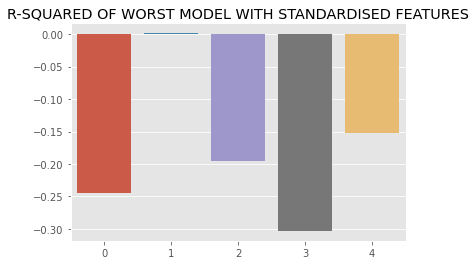

In [133]:
sns.barplot(y=scores, x=np.arange(len(scores)))
plt.title("R-SQUARED OF WORST MODEL WITH STANDARDISED FEATURES")

## Nothing Improved, Let's take some other strategy
### let's dig deeper and check the independent variables relationship with dependent variable 

In [134]:
# import & Train the linear model
import statsmodels.api as sm

# Feature estimation
X2_train = sm.add_constant(X_train_scaled)
X2_test = sm.add_constant(X_test_scaled)
ols = sm.OLS(y_train,X2_train)
lr = ols.fit()
# Print feature summary before feature elimination
print("BEFORE ELIMINATION: \n\n")
print(lr.summary())

BEFORE ELIMINATION: 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 6.708e+04
Date:                Sat, 30 May 2020   Prob (F-statistic):               0.00
Time:                        11:54:22   Log-Likelihood:                -80682.
No. Observations:              140555   AIC:                         1.614e+05
Df Residuals:                  140524   BIC:                         1.617e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6500      0.

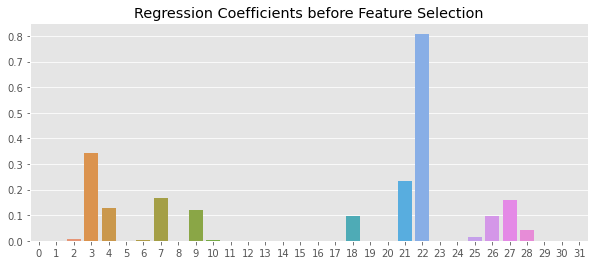

In [135]:
plt.figure(figsize=(10,4))
sns.barplot(y=lr.pvalues, x=np.arange(len(lr.pvalues)))
plt.title("Regression Coefficients before Feature Selection")
plt.show()

### So, it ain't working properly, because most of the X-variables are not compatible with Y-variable
#### Let's inspect them manually, and try fixing the issue

## Feature Selection

In [136]:
train_copy_new.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,4,2018-07-01,4363089508398006729,1530430365,1,1530430365,36,1,1,19,501,2,188,81,7905,268,12,1,1,1,1,0.0,0,3,0,2,5,0,54,6,1,7,2018,3,6,5
1,7,2018-07-22,872438495180459452,1532288393,2,1532288393,37,1,1,19,501,3,81,81,9840,268,16,0,8,0,4,0.0,0,3,0,3,6,1260,159,6,22,7,2018,15,4,3
2,4,2018-07-01,61732750034868310,1530457094,1,1530457094,14,1,1,19,501,2,188,81,10095,268,12,0,11,1,9,0.0,0,3,0,2,5,0,54,6,1,7,2018,10,6,5
3,4,2018-09-27,7810944802312008431,1538089295,2,1538089295,36,0,0,6,388,2,188,69,2017,37,12,0,2,0,2,0.0,0,3,1,2,5,0,54,3,27,9,2018,19,6,5
4,4,2018-10-04,2050355776516988356,1538638689,1,1538638689,14,0,0,16,239,4,187,39,8399,72,13,1,1,1,1,0.0,0,3,0,2,5,0,54,3,4,10,2018,3,1,1


###### date is already converted to micro-components of weekday, dayOfMonth, month & year), so this column is no more required
###### fullVisitorId can't be used in regression, because it indicates a particular visitor, which may cause misconception in the algroithm
###### visitId is used to indicate an individual visit, which makes it non-compatible candidate for regression
###### visit start-time doesn't matter, because data already contain the visit hour on 24-hour scale

In [137]:
train22 = train_copy_new.drop(columns=['date', 'fullVisitorId', 'visitId','visitStartTime']).copy()

In [138]:
train22.head()

,channelGrouping,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,_weekday,_day,_month,_year,_visitHour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,4,1,36,1,1,19,501,2,188,81,7905,268,12,1,1,1,1,0.0,0,3,0,2,5,0,54,6,1,7,2018,3,6,5
1,7,2,37,1,1,19,501,3,81,81,9840,268,16,0,8,0,4,0.0,0,3,0,3,6,1260,159,6,22,7,2018,15,4,3
2,4,1,14,1,1,19,501,2,188,81,10095,268,12,0,11,1,9,0.0,0,3,0,2,5,0,54,6,1,7,2018,10,6,5
3,4,2,36,0,0,6,388,2,188,69,2017,37,12,0,2,0,2,0.0,0,3,1,2,5,0,54,3,27,9,2018,19,6,5
4,4,1,14,0,0,16,239,4,187,39,8399,72,13,1,1,1,1,0.0,0,3,0,2,5,0,54,3,4,10,2018,3,1,1


## MODELING SUBSETS

In [139]:
X1 = train22.iloc[:, :-1].values
y1 = train22.iloc[:, -1].values

In [140]:
#Xtr, X_valid, ytr, y_valid = train_test_split(X1, y1, test_size=0.15, random_state=10)
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=10)

In [141]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140555, 31)
(60239, 31)
(140555,)
(60239,)


In [142]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [143]:
# Apply feature scaling on the data after splitting the data for train and test sets
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## REINSPECT THE X-VARIABLE AND Y-VARIABLE RELATIONSHIP

In [144]:
# import & Train the linear model
import statsmodels.api as sm

# Feature estimation
X2_train = sm.add_constant(X_train_scaled)
X2_test = sm.add_constant(X_test_scaled)
ols = sm.OLS(y_train,X2_train)
lr = ols.fit()
# Print feature summary before feature elimination
print("AFTER ELIMINATION: \n\n")
print(lr.summary())

AFTER ELIMINATION: 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 6.708e+04
Date:                Sat, 30 May 2020   Prob (F-statistic):               0.00
Time:                        11:54:27   Log-Likelihood:                -80682.
No. Observations:              140555   AIC:                         1.614e+05
Df Residuals:                  140524   BIC:                         1.617e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6500      0.0

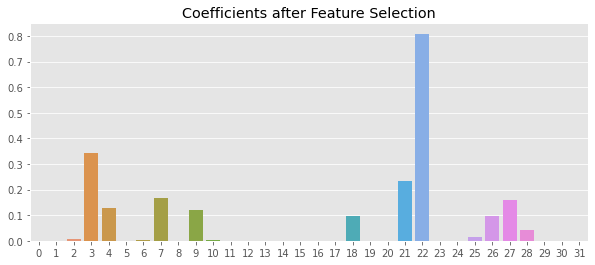

In [145]:
plt.figure(figsize=(10,4))
sns.barplot(y=lr.pvalues, x=np.arange(len(lr.pvalues)))
plt.title("Coefficients after Feature Selection")
plt.show()

#### So, eliminating few bad variables drastically changed the relationship profile
#### Let's begin with this data, and try model fitting

## GOOD MODEL 1:      ORDINARY LEAST SQUARES

In [146]:
ols = linear_model.LinearRegression()
print (ols)
cross_score = cross_val_score(ols, X_train_scaled, y_train, scoring='r2', cv = 5)
print(f"\nCV Average R-squared: {round(cross_score.mean(), 3)}")

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

CV Average R-squared: 0.926


In [147]:
ols.fit(X_train_scaled, y_train)
y_pred = ols.predict(X_test_scaled)

In [148]:
print ("ORDINARY LEAST SQUARES:")
mse_ols = mean_squared_error(y_test, y_pred)
rmse_ols = np.sqrt(mse_ols)
r2score_ols = r2_score(y_test, y_pred)
print("MSE       (testing): %.4f" % mse_ols)
print("RMSE      (testing): %.4f" % rmse_ols)
print("R-squared (testing): %.4f" % r2score_ols)

ORDINARY LEAST SQUARES:
MSE       (testing): 0.1580
RMSE      (testing): 0.3975
R-squared (testing): 0.9369


## GOOD MODEL 2:      RIDGE REGRESSION

In [149]:
Xtr, Xts, ytr, yts = train_test_split(X1, y1, test_size=0.3, random_state=10) 

In [150]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
Xtr_scmm = minmax_scaler.fit_transform(Xtr)
Xts_scmm = minmax_scaler.transform(Xts)

In [151]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 2e4, 5e4, 8e4, 1e5, 1e6, 1e7, 1e8]
clf_ridge = linear_model.RidgeCV(alphas=alphas, store_cv_values=True)
clf_ridge.fit(Xtr_scmm, ytr)

print("alphas: %s" % alphas)
print("Best alpha using built-in RidgeCV: %f" % clf_ridge.alpha_)
print (f"Ridge Regression R-squared: {round ( clf_ridge.score(Xts_scmm, yts), 4)}")

alphas: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000.0, 10000.0, 20000.0, 50000.0, 80000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0]
Best alpha using built-in RidgeCV: 0.100000
Ridge Regression R-squared: 0.9339


In [152]:
#ridge=linear_model.Ridge(alpha=0.1)
#print (ridge)
#cross_score = cross_val_score(ridge, Xtr_scmm, ytr, scoring='r2', cv = 5)
#print(f"\nCV Average R-squared: {round(cross_score.mean(), 3)}")

In [153]:
clf_ridge.fit(Xtr_scmm, ytr)
y_pred = clf_ridge.predict(Xts_scmm)

In [154]:
print ("RIDGE REGRESSION:")
mse_ridge = mean_squared_error(y_test, y_pred)
rmse_ridge = np.sqrt(mse_ridge)
r2score_ridge = r2_score(y_test, y_pred)
print("MSE       (testing): %.4f" % mse_ridge)
print("RMSE      (testing): %.4f" % rmse_ridge)
print("R-squared (testing): %.4f" % r2score_ridge)

RIDGE REGRESSION:
MSE       (testing): 0.1656
RMSE      (testing): 0.4070
R-squared (testing): 0.9339


## GOOD MODEL 3: RANDOM FOREST REGRESSION

In [155]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns


In [156]:
RandomForestRegModel = RandomForestRegressor(n_estimators=100, random_state = 42)
print (RandomForestRegModel)
cross_score = cross_val_score(RandomForestRegModel, Xtr_scmm, ytr, scoring='r2', cv = 5)
print(f"\nCV Average R-squared: {round(cross_score.mean(), 3)}")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

CV Average R-squared: 0.897


In [157]:
RandomForestRegModel.fit(Xtr_scmm, ytr)
y_pred = RandomForestRegModel.predict(Xts_scmm)

In [158]:
print ("RANDOM FOREST REGRESSION:")
mse_rf = mean_squared_error(yts, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2score_rf = r2_score(yts, y_pred)
print("MSE       (testing): %.4f" % mse_rf)
print("RMSE      (testing): %.4f" % rmse_rf)
print("R-squared (testing): %.4f" % r2score_rf)

RANDOM FOREST REGRESSION:
MSE       (testing): 0.0590
RMSE      (testing): 0.2429
R-squared (testing): 0.9764


## GOOD MODEL 4: Gradient Boosting Regression

In [159]:
from sklearn.ensemble import GradientBoostingRegressor

In [160]:
gbr = GradientBoostingRegressor(random_state=0)
print (gbr)
cross_score = cross_val_score(gbr, X_train_scaled, y_train, scoring='r2', cv = 5)
print(f"\nCV Average R-squared: {round(cross_score.mean(), 3)}")

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

CV Average R-squared: 0.891


In [161]:
gbr.fit(X_train_scaled, y_train)
y_pred = gbr.predict(X_test_scaled)

In [162]:
print ("GRADIENT BOOSTING REGRESSION:")
mse_gbr = mean_squared_error(y_test, y_pred)
rmse_gbr = np.sqrt(mse_gbr)
r2score_gbr = r2_score(yts, y_pred)
print("MSE       (testing): %.4f" % mse_gbr)
print("RMSE      (testing): %.4f" % rmse_gbr)
print("R-squared (testing): %.4f" % r2score_gbr)

GRADIENT BOOSTING REGRESSION:
MSE       (testing): 0.1166
RMSE      (testing): 0.3415
R-squared (testing): 0.9534


## GOOD MODEL 5: Adaboost Regression

In [163]:
from sklearn.ensemble import AdaBoostRegressor

In [164]:
abr = AdaBoostRegressor(random_state=0, n_estimators=100)
print (abr)
cross_score = cross_val_score(abr, X_train_scaled, y_train, scoring='r2', cv = 5)
print(f"\nCV Average R-squared: {round(cross_score.mean(), 3)}")

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=0)

CV Average R-squared: 0.642


In [165]:
abr.fit(X_train_scaled, ytr)
y_pred = abr.predict(X_test_scaled)

In [166]:
print ("ADABOOST REGRESSION:")
mse_abr = mean_squared_error(yts, y_pred)
rmse_abr = np.sqrt(mse_abr)
r2score_abr = r2_score(yts, y_pred)
print("MSE       (testing): %.4f" % mse_abr)
print("RMSE      (testing): %.4f" % rmse_abr)
print("R-squared (testing): %.4f" % r2score_abr)

ADABOOST REGRESSION:
MSE       (testing): 0.6251
RMSE      (testing): 0.7906
R-squared (testing): 0.7504


# CLASSIFICATION RESULT ANALYSIS

In [167]:
clf_results = { 
                'ols': {'name': 'Ordinary Least Squares', 'mse' : mse_ols, 'rmse': rmse_ols, 'r2score': r2score_ols},
                'ridge': {'name': 'Ridge Regression', 'mse' : mse_ridge, 'rmse': rmse_ridge, 'r2score': r2score_ridge},
                'rf': {'name': 'Random Forest Regressor', 'mse' : mse_rf, 'rmse': rmse_rf, 'r2score': r2score_rf},
                'gbr': {'name': 'Gradient Boosting Regressor', 'mse' : mse_gbr, 'rmse': rmse_gbr, 'r2score': r2score_gbr},
                'abr': {'name': 'Adaboost Regressor', 'mse' : mse_abr, 'rmse': rmse_abr, 'r2score': r2score_abr}
               }

In [168]:
#clf_results

In [169]:
clf_names = [clf_results[ins]['name'] for ins in clf_results]
clf_mse = [clf_results[ins]['mse'] for ins in clf_results]
clf_rmse = [clf_results[ins]['rmse'] for ins in clf_results]
clf_r2score = [clf_results[ins]['r2score'] for ins in clf_results]

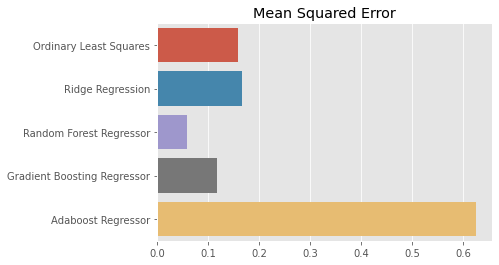

In [170]:
sns.barplot(x=clf_mse, y=clf_names)
plt.title("Mean Squared Error")
plt.show()

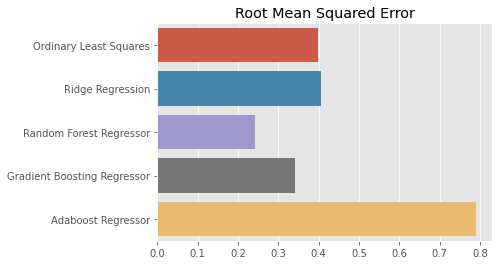

In [171]:
sns.barplot(x=clf_rmse, y=clf_names)
plt.title("Root Mean Squared Error")
plt.show()

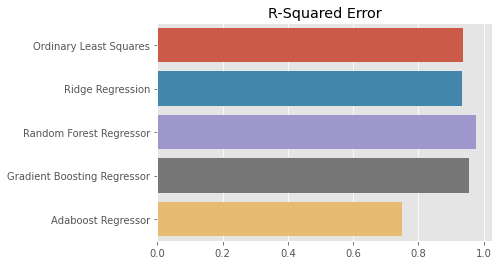

In [172]:
sns.barplot(x=clf_r2score, y=clf_names)
plt.title("R-Squared Error")
plt.show()

## Random Forest is found to be the most reliable regression algorithm in this scenario

## FUTURE WORK
#### To test the neural network regression and deep neural network regression
#### To test XGBoost regression 
#### To validate the auto-feature engineering by appropriately applying labelencoders and dummy variable